# Optical Quantum State Tomography with MaxLikelihood

Shahnawaz Ahmed, Chalmers University of Technology, Sweden  
Email: shahnawaz.ahmed95gmail.com  
GitHub: quantshah  

### Introduction

Quantum State Tomography is the process of determining an unknown quantum state by making measurements on the system and using the measurement data to reconstruct the density matrix of the state. In this notebook, we will use QuTiP to perform Quantum State Tomography of a cavity by counting photon number statistics (see [1]). This type of measurement simply relies on finding the probability of observing a certain number of photons from the cavity, i.e., measuring the photon number operator $|n \rangle  \langle n|$ after displacing the state by applying the displacement operator $$ D(\beta) = e^{\beta a^{\dagger} - \beta^*a}.$$ Then, using the measurement data, one can use some statistical inference technique such as Maximum Likelihood Estimation [2] to reconstruct the density matrix. This is in contrast to other types of tomography, e.g., Homodyne Tomography which relies on quadrature measurements. 

### Optical quantum states in the fock basis

In the fock basis, we can describe optical quantum states as $|\psi \rangle = \sum_n^{N_{cut}}p_n |n \rangle$, where $N_{cut}$ is the photon number cutoff which truncates the Hilbert space and $|{p_n}|^2$ is the probability of observing $n$ photons. One of the most basic state is just a fock state, e.g., the vaccum state $\psi_{vac} = |0 \rangle$ or a superposition of fock states containing two and three photons $\psi_{fock} = \frac{1}{\sqrt{2}}(|2 \rangle + |3 \rangle$. The coherent state is a displaced fock state $\psi_{\texttt{coherent}(\alpha)} = D(\alpha) |0 \rangle$ and a superposition of two such coherent states could be a CAT state,  
$$\psi_{\texttt{CAT}(\alpha)} = \frac{\psi_{\texttt{coherent}}(\alpha) + \psi_{\texttt{coherent}}(-\alpha)}{\sqrt{2}}$$

### Counting photons: measuring the photon number operator $|n \rangle  \langle n|$

The expectation value of the photon number operator can be obtained easily from a state written in the fock basis - it is simply the diagonal elements of the density matrix, $|{p_n}|^2$. Here, we displace the initial state with various values of the displacement, $\beta_i$ and then we can measure the photon number statistics by simply reading the diagonal elements of the displaced density matrix $\rho^{\prime}$.
$$\rho^{\prime} = D(\beta_i) \rho D^{\dagger}(\beta_i)$$

![rop](images/tomography-states.png "rop")

We generate a CAT state and displace it by five different values of $\beta_i$ (left) marked as x. We can see the photon number statistics for various values of displacement (colored bar plots) and the density matrix itself as a hinton plot.

### Iterative Maximum Likelihood Estimation

The measurement statistics from different measurement settings, i.e., values of displacements could be made informationally complete such that they contain the full information required to reconstruct the state, (see Ref [1]). Once we have the data, the iterative Maximum Likelihood Estimation (iMLE) method can be used to start from a random guess of the density matrix and determine the full density matrix by repeatedly applying an operator R.

In [1]:
from IPython.display import HTML, IFrame
HTML('<iframe width="560" height="315" src="images/tomography-reconst.mp4" frameborder="0" allowfullscreen></iframe>')

/Users/shahnawaz/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


$R$ is a function of the measured value of the observable, i.e. frequency of observing a certain number of photons, $f_n$, current estimate of the probability from the density matrix (diagonal elements of reconstructed state), $p_n$ and the measurement setting (the displaced basis in this case, $|y_n \rangle \langle y_n| = D(\beta) |n \rangle \langle n|  D^{\dagger}(\beta)$.

![rop](images/rop.png "rop")

![photonstats](images/photon-stats.png "photon-stats")


## References
[1] Shen, Chao, et al. "Optimized tomography of continuous variable systems using excitation counting." Physical Review A 94.5 (2016): 052327.  
Link: https://arxiv.org/abs/1606.07554

[2] Řeháček, J., Z. Hradil, and M. Ježek. "Iterative algorithm for reconstruction of entangled states." Physical Review A 63.4 (2001): 040303.

In [2]:
import numpy as np

from qutip import Qobj, rand_dm, fidelity, displace, qdiags, qeye, expect
from qutip.states import coherent, coherent_dm, thermal_dm, fock_dm
from qutip.visualization import plot_wigner, hinton
from qutip.wigner import qfunc
import qutip

import matplotlib.pyplot as plt
from matplotlib import animation

# some pretty printing and animation stuff
from IPython.display import clear_output

# Define the operator measured, how to obtain it from a density matrix and the iterative operator for MaxLikelihood.

In [3]:
"""
Iterative Maximum Likelihood estimation based on photon number counting.
"""


def measure_population(beta, rho):
    """
    Measures the photon number statistics for state rho when displaced
    by angle alpha.
    
    Parameters
    ----------    
    alpha: np.complex
        A complex displacement.

    rho:
        The density matrix as a QuTiP Qobj (`qutip.Qobj`)

    Returns
    -------
    population: ndarray
        A 1D array for the probabilities for populations.
    """
    hilbertsize = rho.shape[0]
    # Apply a displacement to the state and then measure the diagonals.

    D = displace(hilbertsize, beta)
    rho_disp = D*rho*D.dag()
    populations = np.real(np.diagonal(rho_disp.full()))
    return populations

def roperator(beta, rho, measured):
    """
    Calculates the iterative ratio operator for measured probability for photons
    (j) to the analytical prediction for some rho.

    Parameters
    ----------
    beta: list_like
        A list of the displacements that were applied to the state before
        measurement.

    rho: `qutip.Qobj`
        The current estimate of the density matrix.

    measured: list_like
        A list of the measurement statistics (diagonal terms) for each beta.

    Returns
    -------
    R: `qutip.Qobj`
        The iterative operator which we are going to apply for state
        reconstruction.
    """
    hilbert_size = rho.shape[0]

    # initialize an empty operator and build it

    R = 0*qeye(hilbert_size)
    calculated_measurements = measure_population(beta, rho)

    for n in range(hilbert_size):
        op = fock_dm(hilbert_size, n)
        D = displace(hilbert_size, beta)
        displaced_D = D.dag()*op*D
        ratio = measured[n]/(calculated_measurements[n] + 1e-6)
        displaced_D = ratio*displaced_D
        R += displaced_D

    return R

# Take an example density matrix for reconstruction

We consider the example in Ref [1]

In [4]:
hilbert_size = 32
alpha_range = 1.9

alphas = np.array([alpha_range, -alpha_range - 1j*alpha_range,
                   -alpha_range + 1j*alpha_range])

rho_true = sum([coherent_dm(hilbert_size, a) for a in alphas])/3

# Displace and measure populations

In [5]:
betas = [1.7, -2, 2.2j, -2.1 - 2.4j, -2 + 2j]
measured_populations = [measure_population(b, rho_true) for b in betas]
width = 1

# Random initial state

In [6]:
random_rho = rand_dm(hilbert_size)

# Wigner function plot and measurement statistics

The x marks the displacement angles.

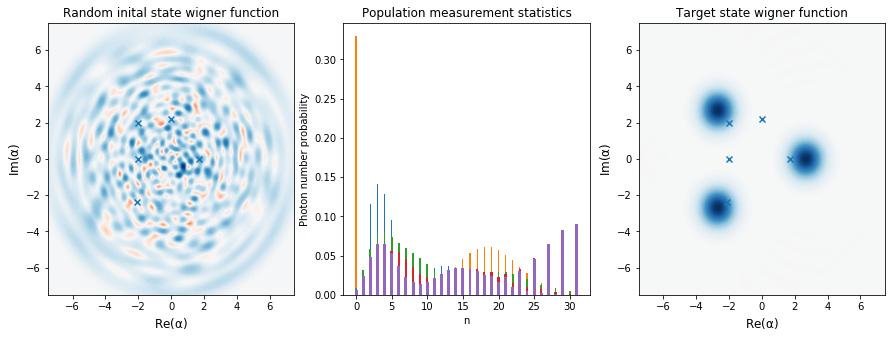

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
indices = np.arange(hilbert_size)

plot_wigner(random_rho, fig, ax[0])
ax[0].scatter(np.real(betas), np.imag(betas), marker="x")
ax[0].set_title("Random inital state wigner function")
for i in range(len(betas)):
    ax[1].bar(indices, measured_populations[i],
              label = r"$beta = {}$".format(i), width=(i+1)/12)

ax[1].set_title("Population measurement statistics")
ax[1].set_xlabel("n")
ax[1].set_ylabel("Photon number probability")


plot_wigner(rho_true, fig, ax[2])
ax[2].scatter(np.real(betas), np.imag(betas), marker="x")
ax[2].set_title("Target state wigner function")
plt.show()

# Iterative Maximum Likelihood Estimation

In [8]:
rho_t = []

In [9]:
max_iter = 150

for iterations in range(max_iter):
    for i in range(len(betas)):
        rho_t.append(random_rho)
        rop = roperator(betas[i], random_rho, measured_populations[i])
        random_rho = rop*random_rho*rop
        
        # Trace renorm
        random_rho = random_rho/random_rho.tr()
        # Compute fidelity
        fidel = fidelity(random_rho, rho_true)

        if iterations % 5 == 0:
            print(r"Fidelity: {}".format(fidel))
            clear_output(wait=0.2)

    if fidel > 0.99:
        break

Fidelity: 0.9893542560074196


# Reconstructed states

<function matplotlib.pyplot.show(*args, **kw)>

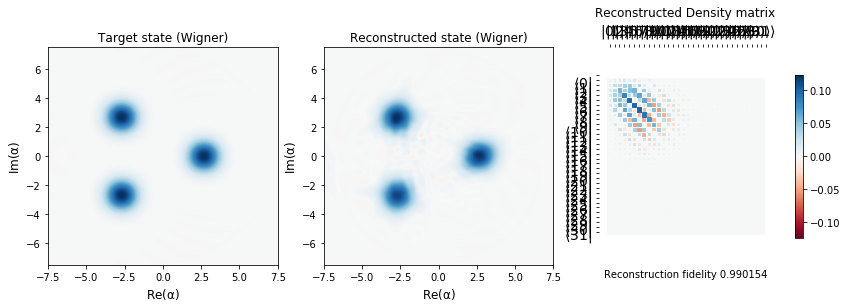

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
plot_wigner(random_rho, fig=fig, ax=ax[1])
plot_wigner(rho_true, fig=fig, ax=ax[0], cmap="RdBu")
hinton(rho_t[-1], ax=ax[2])

ax[0].set_title("Target state (Wigner)")
ax[1].set_title("Reconstructed state (Wigner)")
ax[2].set_title("Reconstructed Density matrix")
ax[2].set_xlabel("Reconstruction fidelity {:2f}".format(fidelity(random_rho, rho_true)))

plt.show

# Population measurement from reconstructed states

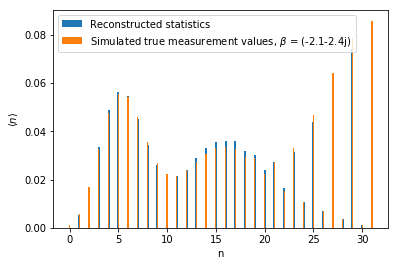

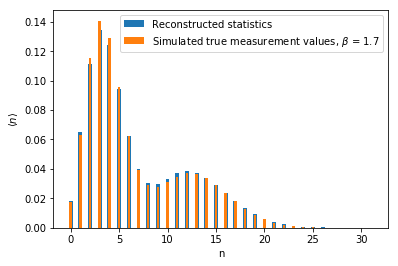

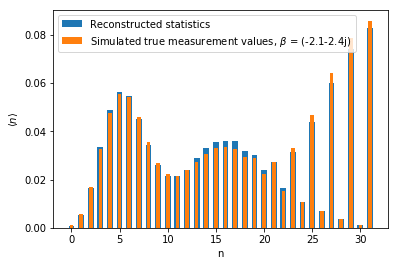

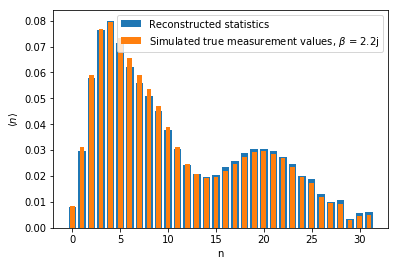

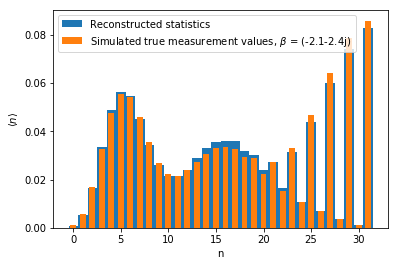

In [11]:
# Chose 5 random displacements
examples = 5

for i in range(examples):
    idx = np.random.choice(range(len(betas)))
    beta = betas[idx]
    measured = measured_populations[idx]
    plt.bar(indices, measure_population(beta, random_rho),
            label = "Reconstructed statistics",
            width=(i+1)/5)
    plt.bar(indices, measured,
            label = r"Simulated true measurement values, $\beta$ = {}".format(
                                                                 np.round(beta,
                                                                          2)),
                                                                 width=(i+1)/8)
    plt.xlabel(r"n")
    plt.ylabel(r"$\langle n \rangle$")
    
    plt.legend()
    plt.show()

# QuTiP details

In [12]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
A. J. Pitchford, P. D. Nation, R. J. Johansson, A. Grimsmo, and C. Granade

QuTiP Version:      4.4.0.dev0+723960fe
Numpy Version:      1.15.0
Scipy Version:      1.3.0
Cython Version:     0.29.6
Matplotlib Version: 3.0.2
Python Version:     3.7.2
Number of CPUs:     6
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Darwin (x86_64)
Installation path:  /Users/shahnawaz/Dropbox/dev/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


# Plot and save the wigner function for making an animation of the MLE

**Make sure you have the images/wigner folder created**. It takes time to get all the images.

In [13]:
# for i in range(len(rho_t)):
#     fig, ax = plt.subplots(1, 2, figsize=(15, 7))
#     indices = np.arange(hilbert_size)
    
#     plot_wigner(rho_t[i], fig, ax[0])
#     ax[0].scatter(np.real(betas), np.imag(betas), marker="x")
#     hinton(rho_t[i], ax=ax[1])
#     ax[1].set_title("Reconstructed Density matrix at iteration {}".format(str(i)))
#     plt.savefig("images/wigner/"+str(i)+".png", bbox_inches='tight')
#     plt.close()

# Make a gif with the Wigner plots

Install `imageio` for this to work.

In [14]:
# import imageio

# png_dir = 'images/wigner/'
# images = []

# interval = 20 # intervals to pick to plot

# for i in range(0, len(rho_t), interval):
#     file_name = str(i)+".png"
#     file_path = os.path.join(png_dir, file_name)
#     images.append(imageio.imread(file_path))

# imageio.mimsave('reconstruction.gif', images, loop=1) #make loop=0 to keep looping

# Convert to mp4 video

Install `moviepy` for this to work

In [15]:
# import moviepy.editor as mp
# clip = mp.VideoFileClip("images/reconstruction.gif")
# clip.write_videofile("images/reconst.mp4", fps=15)